# Autoencoder for MNIST

In [1]:
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

# read data
x_train = pd.read_csv('dataset/mnist_train.csv').values
x_test = pd.read_csv('dataset/mnist_test.csv').values

label_train = pd.read_csv('dataset/mnist_train_lables.csv').values
label = []
for i in range(len(label_train)):
    label.append(label_train[i][0])
y_train = np.asarray(label)

label_test = pd.read_csv('dataset/mnist_test_lables.csv').values
label2 = []
for i in range(len(label_test)):
    label2.append(label_test[i][0])
y_test = np.asarray(label2)

Using TensorFlow backend.


In [2]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
x_train.shape

(10000, 784)

In [4]:
x_test.shape

(2000, 784)

# Basic Autoencoder

In [5]:
######### basic autoencoder #############
encoding_dim = 64

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

# implement AE
autoencoder = Model(input_img, decoded)  
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [7]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

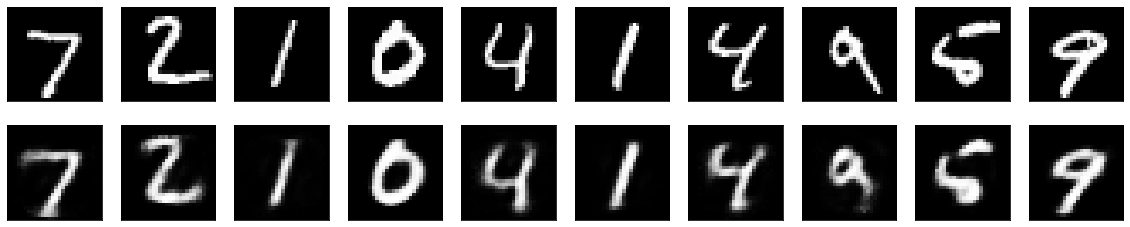

In [8]:
### show image ###

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

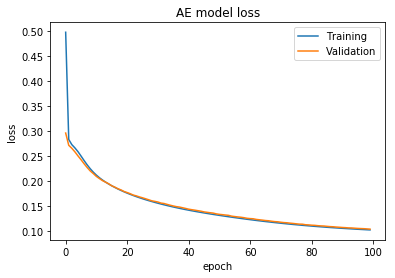

In [9]:
# AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [10]:
## encoded data
encoded_som = pd.DataFrame(encoded_imgs)
#deconded_som = pd.DataFrame(decoded_imgs)

## output data
encoded_data = pd.DataFrame(encoded_som)
encoded_data.to_csv(path_or_buf='output/MNIST_AE_encoded.csv',index= False)

# Sparse Autoencoder

In [11]:
######## sparse autoencoder#######


encoding_dim = 64

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-7))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

ae_train = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

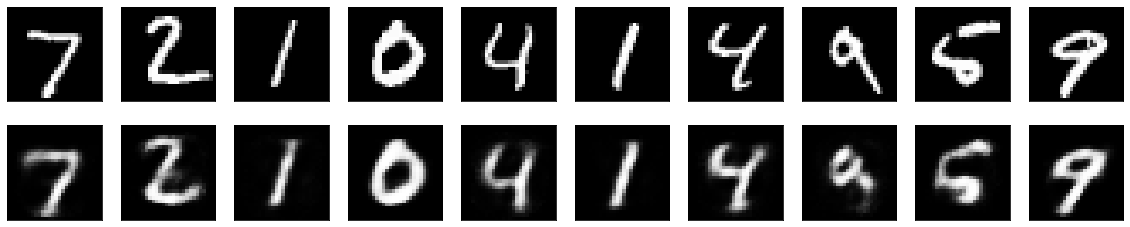

In [12]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

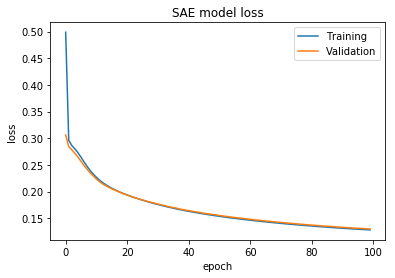

In [13]:
# SAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('SAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [14]:
## encoded data
encoded_som = pd.DataFrame(encoded_imgs)
#deconded_som = pd.DataFrame(decoded_imgs)

## output data
encoded_data = pd.DataFrame(encoded_som)
encoded_data.to_csv(path_or_buf='output/MNIST_SAE_encoded.csv',index= False)

# Contractive Autoencoder

In [15]:
########### Constractive Autoencoder ############
encoding_dim = 64

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation='relu', name = 'encoded')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

lam = 10e-6

def contractive_loss(y_pred, y_true):
    
        mse = K.mean(K.square(y_true - y_pred), axis=1)
        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])
        W = K.transpose(W)
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    
autoencoder.compile(optimizer='adam', loss= contractive_loss)
ae_train = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

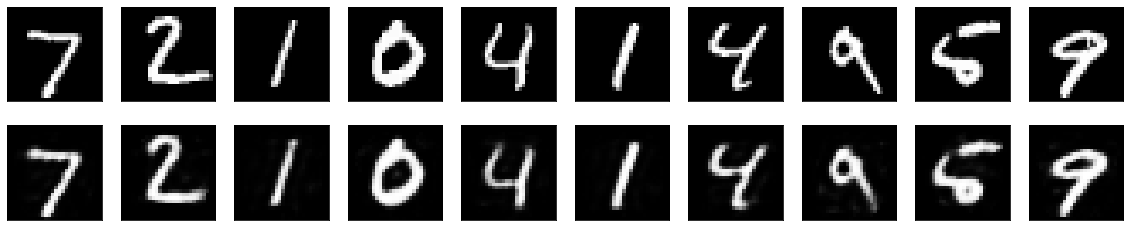

In [16]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

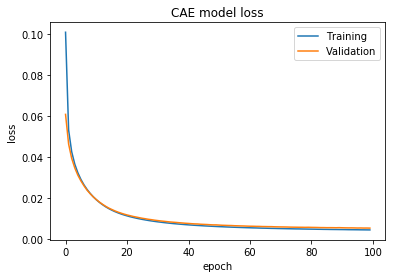

In [17]:
# CAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [18]:
## encoded data
encoded_som = pd.DataFrame(encoded_imgs)
#deconded_som = pd.DataFrame(decoded_imgs)

## output data
encoded_data = pd.DataFrame(encoded_som)
encoded_data.to_csv(path_or_buf='output/MNIST_CAE_encoded.csv',index= False)

# Convolutional Autoencoder

In [19]:
######## Convolutional Autoencoder ########

x_train = x_train.reshape(10000,28,28,1)
x_test = x_test.reshape(2000,28,28,1)

In [20]:
x_train[1].shape

(28, 28, 1)

In [21]:
# plt.imshow(x_test[2])

In [22]:
#encoding_dim = 32

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = input_img
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
shape = K.int_shape(x)
encoded = Flatten()(x)
#encoded = Dense(32, activation='relu', name = 'encoded')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
#latent_inputs = Input(shape=(encoding_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(encoded)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [23]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           1156      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 4)           0         
__________

In [24]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0)

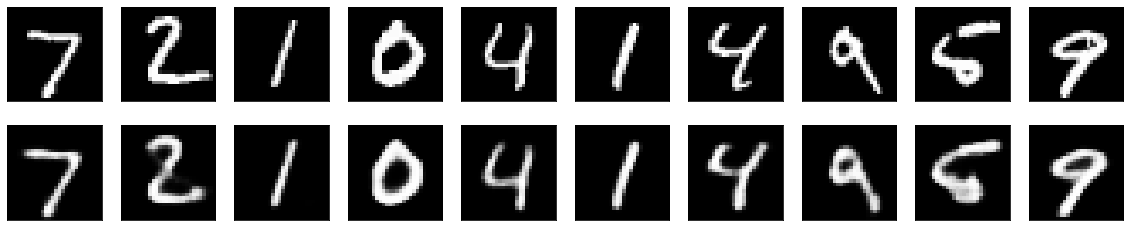

In [25]:

### show image ###

encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1) 
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


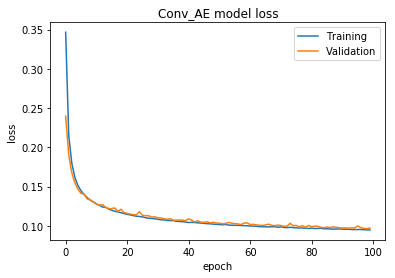

In [26]:
# Convolutional AE loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Conv_AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
#encoded_imgs = encoded_imgs.reshape(2000,-1)

In [28]:
encoded_imgs.shape

(2000, 64)

In [29]:
nonzero = list(map(lambda i: any(encoded_imgs[:,i] != 0), range(encoded_imgs.shape[1])))

encoded_som_nonzero = pd.DataFrame(encoded_imgs[:,nonzero])

## encoded data
encoded_som = pd.DataFrame(encoded_imgs)
#deconded_som = pd.DataFrame(decoded_imgs)

## output data
encoded_som_nonzero.to_csv(path_or_buf='output/MNIST_ConAE_encoded.csv',index= False)

# Denoising Autoencoder

In [30]:
########## Denoising Autoencoder ###########

In [31]:
x_train = x_train.reshape(10000,28,28,1)
x_test = x_test.reshape(2000,28,28,1)

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

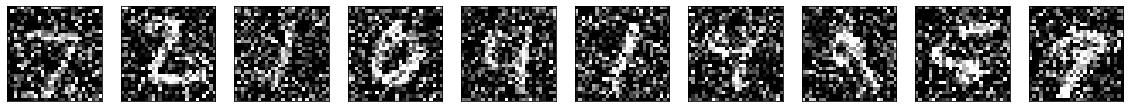

In [32]:
# noisy image
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [33]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = input_img
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#encoded = MaxPooling2D((2, 2), padding='same')(x)
shape = K.int_shape(x)
encoded = Flatten()(x)
#encoded = Dense(128, activation='relu', name = 'encoded')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Dense(shape[1] * shape[2] * shape[3])(encoded)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [34]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 4)           1156      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 4)           0         
__________

In [35]:
ae_train = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=0
                )

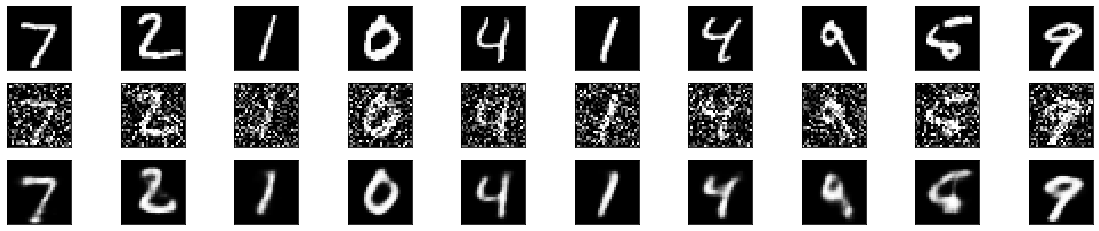

In [36]:

### show image ###

encoded_imgs = encoder.predict(x_test_noisy)
#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy 
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i +2*n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

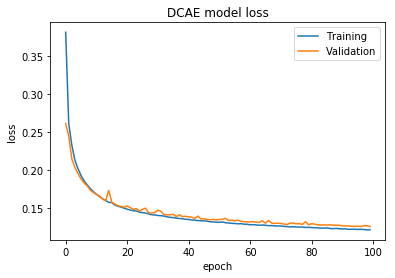

In [37]:
# DCAE loss
plt.plot(ae_train.history['loss'])
plt.plot(ae_train.history['val_loss'])
plt.title('DCAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [38]:
#encoded_imgs = encoded_imgs.reshape(2000,-1)

In [39]:
encoded_imgs.shape

(2000, 64)

In [40]:
## encoded data
encoded_som = pd.DataFrame(encoded_imgs)
#deconded_som = pd.DataFrame(decoded_imgs)

In [41]:
nonzero = list(map(lambda i: any(encoded_imgs[:,i] != 0), range(encoded_imgs.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_imgs[:,nonzero])


## output data
encoded_som_nonzero.to_csv(path_or_buf='output/MNIST_DCAE_encoded.csv',index= False)